이번 실습 data preprocess는 모두 gan GDL github 참고

In [1]:
from utils.write import training_data, test_data, collapse_documents, expand_answers, _read_data, glove
training_data_gen = training_data()
# training_data_gen = [next(training_data_gen)]
test_data_gen = test_data()


dimensions 100


In [2]:
t = next(training_data_gen)

In [3]:
idx = 0

print('document_tokens\n', t['document_tokens'][idx])
print('\n')
print('question_input_tokens\n', t['question_input_tokens'][idx])
print('\n')
print('answer_masks\n', t['answer_masks'][idx])
print('\n')
print('answer_labels\n', t['answer_labels'][idx])
print('\n')
print('question_output_tokens\n', t['question_output_tokens'][idx])

document_tokens
 [3695    5  856    1 4601    1   66    4  219   99  216   10  856 3345
   15 1119  339   29   33 3854  221    8 2630 6558    5   28   22  194
  676 2743   10    4  123   12  139    6   29   54  410   33  909   11
  529    7  194  821   10 6558    5   35   23   12  162 5156   66  124
   91    1 6167    1 4571   66    8  159   30  151 1399  963   64    5
   28 2683 3549 9316  154   11 1076  172  447  183   20  796    1    5
    4  940  597 2077 2017    8    4  123    6    4  172  447    1   20
   11  527   24   99  496    7  474  889 3289    5   39   18   53    8
  699   20 4571    6 9316 2601   11  178  952   95 1086   10    4 5393
 6558  623   22  199   22   38  738    5   35  150    1    9 9316 6711
   15  181  209    1 2854  706   13 9952 1119  399  106   30 1999   87
 1086    6  120   22   10    4  396    1  952    5    4  714    5   40
   19    5   17    8 1860    4  279    7    4 1723   70    6   29  102
   42  268   54  461 2240   60  821   10  856  433   17   84

In [4]:
# GloVe

VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

print('GLOVE')
print('VOCAB_SIZE: ', VOCAB_SIZE)
print('EMBEDDING_DIMENS: ', EMBEDDING_DIMENS)

GRU_UNITS = 100

GLOVE
VOCAB_SIZE:  9984
EMBEDDING_DIMENS:  100


In [5]:
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

In [14]:
import numpy as np
import torch
from collections import Counter
import re
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import RMSprop,Adam

class answerMask(nn.Module):
    def __init__(self,seq_length=200):
        super().__init__()
        self.seq_length = 200    
        self.n_units = 128
        embedding_size = self.n_units #n_units에 맞추기
        total_words = 9984 # gloVe dim에 맞추기
        self.num_layers = 1 #적층 레이어를 위해
        self.batch_size =1

        self.embed = nn.Embedding(
            num_embeddings=total_words, embedding_dim= embedding_size
        )
        self.answer_mask_gru = nn.GRU(
            input_size=self.n_units,
            hidden_size=self.n_units,
            batch_first=True,
            dropout=0.2,            
        )
        self.answer_mask = nn.Sequential(
            nn.Linear(self.n_units,2), 
            nn.Softmax(), 
        )

        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(),lr=0.001)
    def forward(self,x,prev_state):  
        # [126, 200]
        print("x.shape",x.shape)
        emb_init = self.embed(x) 
        # [126, 200, 128] #prev_state [1, 126, 128]을 원함
        print("emb_init.shape",emb_init.shape)
        self.output,state =self.answer_mask_gru(emb_init,prev_state)
        # [126, 200, 128] [1, 126, 128]
        print("self.output.shape",self.output.shape)
        print("state.shape",state.shape)
        mask = self.answer_mask(self.output)
        # [126, 200, 2]
        print("mask.shape",mask.shape)
        return mask 

    def init_state(self):
        return torch.zeros(self.num_layers, self.batch_size, self.n_units)
    
    def build_loss(self,document,answer_label):
        self.batch_size = document.shape[0]
        state_h = self.init_state()
        self.optimizer.zero_grad()

        y_pred = self.forward(document, state_h)
        y_pred = y_pred.view(-1,2)
        loss = self.loss_fn(y_pred, answer_label)

        # loss.backward()
        # self.optimizer.step()

        return loss
        
        


In [65]:
class QnAEncoderDecoderModel(nn.Module):
    def __init__(self,seq_length=20):
        super().__init__()
        
        # n_units = 256
        # embedding_size = 100
        self.seq_length =200
        self.n_units = 128
        self.num_layers = 1 #적층 레이어를 위해
        self.total_words = 9984 # gloVe dim에 맞추기
        
        self.encoder_gru = nn.GRU(
            input_size=self.n_units,
            hidden_size=self.n_units,
            batch_first=True,
            dropout=0.2,            
        )

        self.decoder_gru = nn.GRU(
            input_size=self.n_units,
            hidden_size=self.n_units,
            batch_first=True,
            dropout=0.2,            
        )

        self.fc = nn.Sequential(
            nn.Linear(self.n_units,self.total_words),
            nn.Softmax(),
        )      
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(),lr=0.001)
        self.dec_state =None #나중에 질문 생성을 위해

    def forward(self,encoder_inputs,question,prev_state):  
        # encoder_inputs [126, 25, 128]  #h_0 [1, 126, 128]을 원함. [1, 25, 128]
        print("encoder_inputs.shape",encoder_inputs.shape)
        print("question.shape",question.shape)
        enc_output,enc_state = self.encoder_gru(encoder_inputs,prev_state)
        # [126, 25, 128], [1, 126, 128]
        print("enc_output.shape",enc_output.shape)
        print("enc_state.shape",enc_state.shape)
        # question [126, 13]
        emb_question = self.embed(question).detach()
        # [126, 13, 128]
        print("emb_question.shape",emb_question.shape)
        dec_output,self.dec_state = self.decoder_gru( emb_question ,enc_state)
        # [126, 13, 128], [1, 126, 128]
        print("dec_output.shape",dec_output.shape)
        print("dec_state.shape",self.dec_state.shape)

        logits = self.fc(dec_output) 
        print("logits.shape",logits.shape)
        #[126, 13, 9984]
        return logits
    
    def init_state(self):
        return torch.zeros(self.num_layers, self.batch_size, self.n_units)

    def answerMaskDotAnswerOutputs(self,answer_mask_label,answer_outputs):
        # [119, 51, 200] x [119, 200, 512]
        encoder_inputs = torch.bmm(answer_mask_label,answer_outputs)
        # [119, 51, 512]
        return encoder_inputs

    def predictY(self,answer_mask_model,question_input_token,answer_mask_label):
        self.embed = answer_mask_model.embed
        
        encoder_inputs = self.answerMaskDotAnswerOutputs(answer_mask_label,answer_mask_model.output)
        
        self.batch_size=encoder_inputs.shape[0]
        state_h = self.init_state()
        self.optimizer.zero_grad()
        
        y_pred = self.forward(encoder_inputs,question_input_token, state_h)
        return y_pred

    def build_loss(self,answer_mask_model,question_input_token,question_output_token,answer_mask_label):
        y_pred = self.predictY(answer_mask_model,question_input_token,answer_mask_label)
        y_pred = y_pred.view(-1,self.total_words)
        loss = self.loss_fn(y_pred, question_output_token)

        # loss.backward()
        # self.optimizer.step()

        return loss

In [66]:
answer_mask_model = answerMask()
qna_model = QnAEncoderDecoderModel()

d:\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [13]:
import numpy as np

training_loss_hist = []
test_loss_hist = []

#EPOCHS = 2000
EPOCHS = 1
start_epoch = 1
for epoch in range(start_epoch, start_epoch + EPOCHS + 1):
    print("에포크 {0}".format(epoch))
    
    for i, batch in enumerate(training_data()):
        
        val_batch = next(test_data_gen, None)
        
        if val_batch is None:
            test_data_gen = test_data()
            val_batch = next(test_data_gen, None)
        print('hi')
        answer_training_loss = answer_mask_model.build_loss(
            torch.LongTensor( batch['document_tokens']),
            torch.LongTensor(batch['answer_labels'].flatten()),
        )
        print('===hi===')
        decoder_training_loss = qna_model.build_loss(
            answer_mask_model,
            torch.LongTensor(batch['question_input_tokens']),
            torch.LongTensor(batch['question_output_tokens'].flatten()),
            torch.FloatTensor( batch['answer_masks']),
        )
        
    
        
        total_loss = answer_training_loss+ decoder_training_loss
        training_loss_hist.append(total_loss.item())
        total_loss.backward()
        answer_mask_model.optimizer.step()
        qna_model.optimizer.step()


        print(f"{i}: 훈련 손실: {total_loss.item():.4f}")    
        if i==1:
            break
#    if epoch % 100 == 0:
#        print(f"{i}: 훈련 손실: {total_loss:.4f}")    
    break

에포크 1
hi
x.shape torch.Size([126, 200])
emb_init.shape torch.Size([126, 200, 128])
self.output.shape torch.Size([126, 200, 128])
state.shape torch.Size([1, 126, 128])
mask.shape torch.Size([126, 200, 2])
===hi===
encoder_inputs.shape torch.Size([126, 42, 128])
question.shape torch.Size([126, 17])
enc_output.shape torch.Size([126, 42, 128])
enc_state.shape torch.Size([1, 126, 128])
emb_question.shape torch.Size([126, 17, 128])
dec_output.shape torch.Size([126, 17, 128])
dec_state.shape torch.Size([1, 126, 128])


d:\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


logits.shape torch.Size([126, 17, 9984])
0: 훈련 손실: 9.9012
hi
x.shape torch.Size([128, 200])
emb_init.shape torch.Size([128, 200, 128])
self.output.shape torch.Size([128, 200, 128])
state.shape torch.Size([1, 128, 128])
mask.shape torch.Size([128, 200, 2])
===hi===
encoder_inputs.shape torch.Size([128, 25, 128])
question.shape torch.Size([128, 15])
enc_output.shape torch.Size([128, 25, 128])
enc_state.shape torch.Size([1, 128, 128])
emb_question.shape torch.Size([128, 15, 128])
dec_output.shape torch.Size([128, 15, 128])
dec_state.shape torch.Size([1, 128, 128])
logits.shape torch.Size([128, 15, 9984])
1: 훈련 손실: 9.9008


## 테스트  
gan gdl 참고 후 수정

In [42]:
test_data_gen = test_data()
batch = next(test_data_gen)
batch = collapse_documents(batch)
idx=0
print(batch['document_words'][idx][37:50])
for i in range(len(batch['document_words'][idx])):
    print(i, batch['document_words'][idx][i])

['july', '31st', '2005', '.', '']
0 the
1 winning
2 goal
3 was
4 scored
5 by
6 23-year-old
7 striker
8 joe
9 bloggs
10 during
11 the
12 match
13 between
14 arsenal
15 and
16 barcelona
17 .
18 arsenal
19 recently
20 signed
21 the
22 striker
23 for
24 50
25 million
26 pounds
27 .
28 the
29 next
30 match
31 is
32 in
33 two
34 weeks
35 time,
36 on
37 july
38 31st
39 2005
40 .
41 


x.shape torch.Size([1, 42])
emb_init.shape torch.Size([1, 42, 128])
self.output.shape torch.Size([1, 42, 128])
state.shape torch.Size([1, 1, 128])
mask.shape torch.Size([1, 42, 2])
예측한 대답의 확률


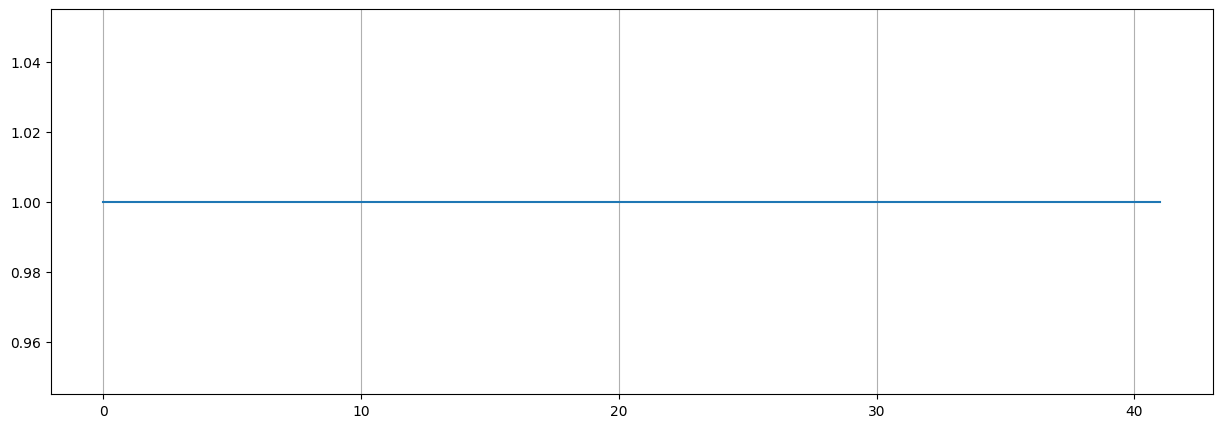

0 the 1.0
1 winning 1.0
2 goal 1.0
3 was 1.0
4 scored 1.0
5 by 1.0
6 23-year-old 1.0
7 striker 1.0
8 joe 1.0
9 bloggs 1.0
10 during 1.0
11 the 1.0
12 match 1.0
13 between 1.0
14 arsenal 1.0
15 and 1.0
16 barcelona 1.0
17 . 1.0
18 arsenal 1.0
19 recently 1.0
20 signed 1.0
21 the 1.0
22 striker 1.0
23 for 1.0
24 50 1.0
25 million 1.0
26 pounds 1.0
27 . 1.0
28 the 1.0
29 next 1.0
30 match 1.0
31 is 1.0
32 in 1.0
33 two 1.0
34 weeks 1.0
35 time, 1.0
36 on 1.0
37 july 1.0
38 31st 1.0
39 2005 1.0
40 . 1.0
41  1.0


In [44]:
import matplotlib.pyplot as plt

# 대답 위치 예측

plt.figure(figsize=(15,5))
idx = 0

answer_mask_model.batch_size = torch.LongTensor( batch['document_tokens']).shape[0]
answer_preds = answer_mask_model(torch.LongTensor( batch['document_tokens']),answer_mask_model.init_state())

print('예측한 대답의 확률')
ax = plt.gca()
ax.xaxis.grid(True)
plt.plot(answer_preds[idx, :, 1].detach().numpy())
plt.show()

for i in range(len(batch['document_words'][idx])):
    print(i, batch['document_words'][idx][i], np.round(answer_preds[idx][i][1].detach().numpy(),2))

In [45]:
# 대답 위치 선정

start_answer = 37
end_answer = 39

print(batch['document_words'][idx][start_answer:(1+end_answer)])

['july', '31st', '2005']


In [50]:
answer_mask_model.batch_size = torch.LongTensor( batch['document_tokens']).shape[0]
answer_preds = answer_mask_model(torch.LongTensor( batch['document_tokens']),answer_mask_model.init_state())

answers = [[0] * len(answer_preds[idx])]
for i in range(start_answer, end_answer + 1):
    answers[0][i] = 1

answer_batch = expand_answers(batch, answers)
print(answer_batch['document_tokens'][[idx]])

x.shape torch.Size([1, 42])
emb_init.shape torch.Size([1, 42, 128])
self.output.shape torch.Size([1, 42, 128])
state.shape torch.Size([1, 1, 128])
mask.shape torch.Size([1, 42, 2])
[[   4  873  714   18  874   24 9870 3183 1959    1  105    4  549  118
  3562    9 3567    6 3562  742  756    4 3183   13  691   94 1678    6
     4  182  549   17   10   56  516    1   16  374    1  708    6    1]]


d:\miniconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [73]:
from utils.write import START_TOKEN, END_TOKEN, look_up_token

answer_mask_model.batch_size = torch.LongTensor( batch['document_tokens']).shape[0]
answer_preds = answer_mask_model(torch.LongTensor( batch['document_tokens']),answer_mask_model.init_state())

answers = [[0] * len(answer_preds[idx])]
for i in range(start_answer, end_answer + 1):
    answers[0][i] = 1

answer_batch = expand_answers(batch, answers)
with torch.no_grad():
    qna_model.predictY(
        answer_mask_model,
        torch.LongTensor( answer_batch['document_tokens'][[idx]]), 
        torch.FloatTensor(answer_batch['answer_masks'][[idx]]))
    next_decoder_init_state = qna_model.dec_state
    print("next_decoder_init_state.shape",next_decoder_init_state.shape)

    word_tokens = [START_TOKEN]
    questions = [look_up_token(START_TOKEN)]

    ended = False
    counter = 0

    while not ended:
        
        counter += 1
        #print("torch.LongTensor(word_tokens)",torch.LongTensor(word_tokens).unsqueeze(1).shape)
        emb_output=qna_model.embed(torch.LongTensor(word_tokens).unsqueeze(1))
        #print("emb_output",emb_output.shape)
        decoder_output, next_decoder_init_state = qna_model.decoder_gru( 
            emb_output,
            next_decoder_init_state)
        
        word_preds = qna_model.fc(decoder_output)
        #print("word_preds.shape",word_preds.shape)
        word_tokens = torch.argmax(word_preds, 2)[0]
        print("look_up_token(word_tokens[0].detach().numpy())",look_up_token(word_tokens[0].detach().numpy()))
        questions.append(look_up_token(word_tokens[0].detach().numpy()))

        if word_tokens[0] == END_TOKEN or counter > 20 :
            ended = True

    questions = ' '.join(questions)

x.shape torch.Size([1, 42])
emb_init.shape torch.Size([1, 42, 128])
self.output.shape torch.Size([1, 42, 128])
state.shape torch.Size([1, 1, 128])
mask.shape torch.Size([1, 42, 2])
encoder_inputs.shape torch.Size([1, 3, 128])
question.shape torch.Size([1, 42])
enc_output.shape torch.Size([1, 3, 128])
enc_state.shape torch.Size([1, 1, 128])
emb_question.shape torch.Size([1, 42, 128])
dec_output.shape torch.Size([1, 42, 128])
dec_state.shape torch.Size([1, 1, 128])
logits.shape torch.Size([1, 42, 9984])
next_decoder_init_state.shape torch.Size([1, 1, 128])
look_up_token(word_tokens[0].detach().numpy()) <PAD>
look_up_token(word_tokens[0].detach().numpy()) <PAD>
look_up_token(word_tokens[0].detach().numpy()) <PAD>
look_up_token(word_tokens[0].detach().numpy()) <PAD>
look_up_token(word_tokens[0].detach().numpy()) <PAD>
look_up_token(word_tokens[0].detach().numpy()) <PAD>
look_up_token(word_tokens[0].detach().numpy()) <PAD>
look_up_token(word_tokens[0].detach().numpy()) <PAD>
look_up_token(w

In [ ]:
test_data_gen = test_data()
batch = next(test_data_gen)
batch = collapse_documents(batch)

In [44]:
batch['document_tokens'].shape

(128, 200)

In [45]:
print(batch['answer_labels'].shape)
np.expand_dims(batch['answer_labels'], axis = -1).shape

(128, 200)


(128, 200, 1)

In [11]:
print(batch['question_output_tokens'].shape)
np.expand_dims(batch['question_output_tokens'], axis = -1).shape

(121, 18)


(121, 18, 1)

In [ ]:
import matplotlib.pyplot as plt

# 대답 위치 예측

plt.figure(figsize=(15,5))
idx = 0

answer_preds = answer_model.predict(batch["document_tokens"])

print('예측한 대답의 확률')
ax = plt.gca()
ax.xaxis.grid(True)
plt.plot(answer_preds[idx, :, 1])
plt.show()

for i in range(len(batch['document_words'][idx])):
    print(i, batch['document_words'][idx][i], np.round(answer_preds[idx][i][1],2))

In [13]:
# 대답 위치 선정

start_answer = 37
end_answer = 39
print(batch['document_words'][idx][start_answer:(1+end_answer)])
print(batch['document_words'][idx])


['july', '31st', '2005']
['the', 'winning', 'goal', 'was', 'scored', 'by', '23-year-old', 'striker', 'joe', 'bloggs', 'during', 'the', 'match', 'between', 'arsenal', 'and', 'barcelona', '.', 'arsenal', 'recently', 'signed', 'the', 'striker', 'for', '50', 'million', 'pounds', '.', 'the', 'next', 'match', 'is', 'in', 'two', 'weeks', 'time,', 'on', 'july', '31st', '2005', '.', '']


In [22]:
answers = [[0] * 40]
for i in range(start_answer, end_answer + 1):
    answers[0][i] = 1
    print(answers)

answer_batch = expand_answers(batch, answers)
answer_batch['document_tokens'][[0]]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]]


array([[   4,  873,  714,   18,  874,   24, 9870, 3183, 1959,    1,  105,
           4,  549,  118, 3562,    9, 3567,    6, 3562,  742,  756,    4,
        3183,   13,  691,   94, 1678,    6,    4,  182,  549,   17,   10,
          56,  516,    1,   16,  374,    1,  708,    6,    1]])

In [23]:
answer_batch['answer_masks'][[idx]]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]])

In [ ]:
answer_preds = answer_model.predict(batch["document_tokens"])

answers = [[0] * len(answer_preds[idx])]
for i in range(start_answer, end_answer + 1):
    answers[0][i] = 1

answer_batch = expand_answers(batch, answers)

next_decoder_init_state = decoder_initial_state_model.predict([answer_batch['document_tokens'][[idx]], answer_batch['answer_masks'][[idx]]])

word_tokens = [START_TOKEN]
questions = [look_up_token(START_TOKEN)]

ended = False
counter = 0

while not ended:
    
    counter += 1

    word_preds, next_decoder_init_state = question_model.predict([word_tokens, next_decoder_init_state])

    next_decoder_init_state = np.squeeze(next_decoder_init_state, axis = 1)
    word_tokens = np.argmax(word_preds, 2)[0]

    questions.append(look_up_token(word_tokens[0]))

    if word_tokens[0] == END_TOKEN or counter > 20 :
        ended = True

questions = ' '.join(questions)